In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel
from torch_training import train_epoch
from torch_perturb.torch_pert_topk import PerturbedTopK

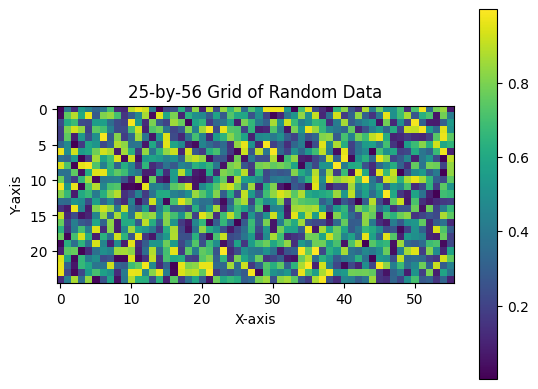

In [2]:
# create a 20-by-70 grid of random data and plot it as an image
data = np.random.rand(25, 56)

# Step 2: Plot the data as an image
plt.imshow(data, cmap='viridis', aspect='equal')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('25-by-56 Grid of Random Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

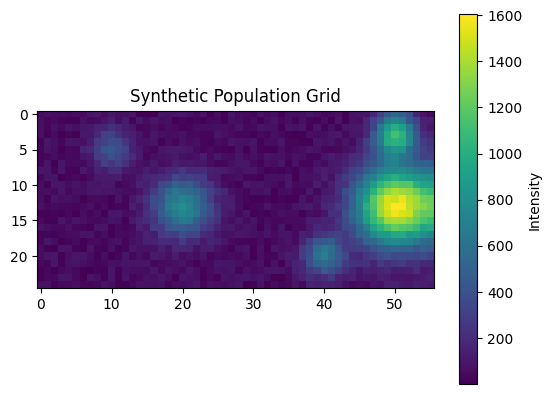

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# set seed
np.random.seed(0)

# Step 1: Create the grid with low random values
grid_size = (25, 56)  # Define the size of the grid
low_value = 100
pop_grid = np.random.rand(*grid_size) * low_value

# Step 2: Add Gaussian clusters
num_clusters = 5
cluster_centers = [(13,50), (3, 50), (13, 20), (20, 40), (5, 10)]
cluster_highs = np.array([3000, 500, 800, 300, 200])*50
cluster_sigmas = np.array([4, 2, 3, 2, 2])

# Add clusters to the grid
for center, high, sigma in zip(cluster_centers, cluster_highs, cluster_sigmas):
    x, y = center
    cluster_size = np.zeros(grid_size)
    cluster_size[x, y] = high  # Start with a high value at the center

    cluster_size = gaussian_filter(cluster_size, sigma=sigma)  # Apply Gaussian filter

    pop_grid += cluster_size

# Step 3: Plot the grid
plt.imshow(pop_grid, cmap='viridis')
plt.colorbar(label='Intensity')
plt.title('Synthetic Population Grid')
plt.show()


In [4]:
def create_v_shape(center_position,  v_length, grid_size, value=2.5, direction='left', filter_sigma=1):
    """Create a V-shaped pattern centered at the specified position."""
    grid = np.zeros(grid_size)
    x_center, y_center = center_position

    if direction == 'left':
        first_x_offset_sign = 1
        second_x_offset_sign = -1
        first_y_offset_sign = 1
        second_y_offset_sign = 1
    elif direction == 'right':
        first_x_offset_sign = 1
        second_x_offset_sign = -1
        first_y_offset_sign = -1
        second_y_offset_sign = -1
    elif direction == 'up':
        first_x_offset_sign = 1
        second_x_offset_sign = 1
        first_y_offset_sign = 1
        second_y_offset_sign = -1
    elif direction == 'down':
        first_x_offset_sign = -1
        second_x_offset_sign = -1
        first_y_offset_sign = 1
        second_y_offset_sign = -1

    
    for offset in range(0, v_length + 1):
        # Calculate positions for the V branches
        first_branch_position = (x_center + first_x_offset_sign*offset, y_center + first_y_offset_sign*offset)
        second_branch_position = (x_center + second_x_offset_sign*offset, y_center + second_y_offset_sign*offset)
        
        # Ensure branches are within grid boundaries
        if 0 <= first_branch_position[0] < grid_size[0] and 0 <= first_branch_position[1] < grid_size[1]:
            grid[first_branch_position] = value
        
        if 0 <= second_branch_position[0] < grid_size[0] and 0 <= second_branch_position[1] < grid_size[1]:
            grid[second_branch_position] = value
    
    return gaussian_filter(grid, sigma=sigma)

In [5]:
death_rates = []
deaths = []
#north_south_init = (0, 52)
east_west_init = (12, 52)
frames = 64
for time in range(frames):
    #north_south_loc = (north_south_init[0]+time, north_south_init[1])
    #north_south_v = create_v_shape(north_south_loc, np.max(grid_size), grid_size, direction='down')

    #if north_south_loc[0] == east_west_init[0]:
    start_time = 0
    #if north_south_loc[0] >= east_west_init[0]:
    east_west_loc = (east_west_init[0], east_west_init[1]-time+start_time)
    east_west_v = create_v_shape(east_west_loc, np.max(grid_size), grid_size,value=5, direction='left')
    #else:
    #    east_west_v = np.zeros(grid_size)

    
    grid = np.zeros(grid_size)  + east_west_v + np.random.rand(*grid_size)*0.1
    death_rate = grid*0.005
    death_rates.append(death_rate)
    deaths.append(pop_grid*death_rate)

In [6]:
def update_death(frame):
    global deaths
    img.set_data(deaths[frame])
    return [img]

def update_death_rate(frame):
    global death_rates
    img.set_data(death_rates[frame])
    return [img]

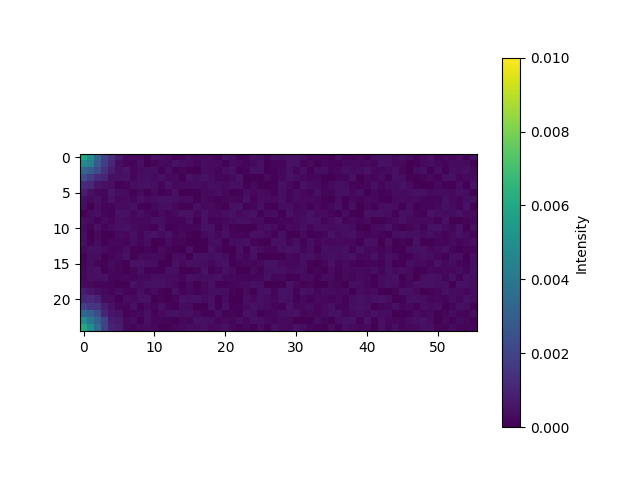

In [7]:
%matplotlib widget
# Prepare the figure for animation
fig, ax = plt.subplots()
img = ax.imshow(grid, cmap='viridis', vmin=0, vmax=0.01)
plt.colorbar(img, label='Intensity')



# Animate the grid
ani = animation.FuncAnimation(fig, update_death_rate, frames=frames, interval=100, blit=True)
ani.save('death_rates1.mp4')


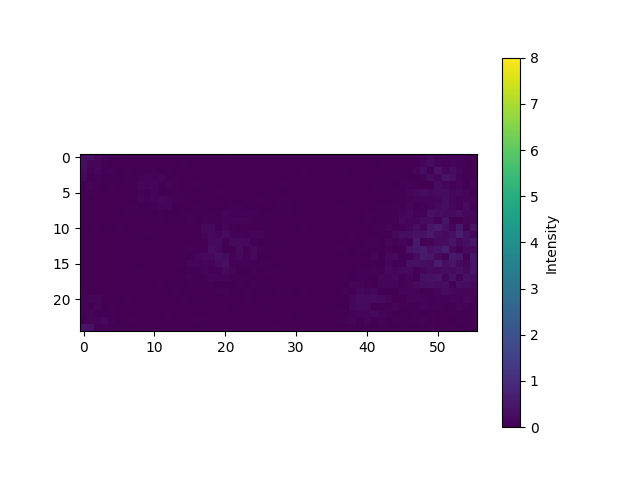

In [8]:
%matplotlib widget
# Prepare the figure for animation
fig, ax = plt.subplots()
img = ax.imshow(grid, cmap='viridis', vmin=0, vmax=8)
plt.colorbar(img, label='Intensity')



# Animate the grid
ani = animation.FuncAnimation(fig, update_death, frames=frames, interval=100, blit=True)
ani.save('deaths.mp4')



In [9]:
import pandas as pd
full_df = pd.DataFrame()
for time in range(frames):
    num_rows = grid_size[0]*grid_size[1]
    geoid_col = np.arange(num_rows)
    time_col = time * np.ones(num_rows)
    death_rate_col = death_rates[time].flatten()
    death_col = deaths[time].flatten()
    df = pd.DataFrame({'geoid': geoid_col, 'time': time_col, 'death_rate': death_rate_col, 'death': death_col})
    full_df = pd.concat([full_df, df], ignore_index=True)

In [10]:
full_df.to_csv('deaths1.csv', index=False)

In [11]:
pop_df = pd.DataFrame({'geoid': geoid_col, 'pop': pop_grid.flatten()})
pop_df.to_csv('pop1.csv', index=False)

In [12]:
pop_df

,geoid,pop
0,0,54.881350
1,1,71.518937
2,2,60.283685
3,3,54.536231
4,4,42.608799
...,...,...
1395,1395,113.268615
1396,1396,110.419922
1397,1397,143.571583
1398,1398,130.353352
